In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from collections import Counter
import os
import cv2
from sklearn.utils import shuffle
import numpy as np
import math
from tqdm import tqdm
from pathlib import Path
import albumentations as A
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import random


In [ ]:
A.seed_everything(42)


np.random.seed(42)
random.seed(42)

AttributeError: 'builtin_function_or_method' object has no attribute 'seed'

In [179]:
#declare variables and create augmented directories
dataset_path = "../dataset"
n_augmented_class=500
image_size = (224, 224)
classes = ["glass", "paper", "cardboard", "plastic", "metal", "trash"]
unknown_class = "unknown"
n_augmented_unknown=550
#delete existing augmented files
dataset_path = Path(dataset_path)  # make sure it's a Path object

for cls in classes:
    aug_dir = dataset_path  / cls/ "augmented"

    # Create folder if not exists
    aug_dir.mkdir(parents=True, exist_ok=True)

    # Delete all existing files inside
    for file in aug_dir.iterdir():
        if file.is_file():
            file.unlink()

In [180]:
all_files = []
all_labels = []

for idx, cls in enumerate(classes):
    class_folder = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_folder):
        print(f"Warning: Folder not found: {class_folder}")
        continue

    for f in os.listdir(class_folder):
        if not (f.endswith(".jpg") or f.endswith(".png")):
            continue
        file_path = os.path.join(class_folder, f)

        img = cv2.imread(file_path)
        if img is None:
            print(f"Warning: Cannot open image {file_path}, skipping.")
            continue
        all_files.append(file_path)
        all_labels.append(idx)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, test_size=0.25, shuffle=True, stratify=all_labels
)

In [181]:
# Define augmentation pipeline for training data without unknown class
transform = A.Compose([
  A.SomeOf([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=45, p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.0,      
            scale_limit=0.2,
            rotate_limit=0,
            border_mode=0,
            p=0.5
        ),
        A.RandomCrop(width=128, height=128, p=0.5),
    ], n=3),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=1.0
        ),
        A.HueSaturationValue(
            hue_shift_limit=10,
            sat_shift_limit=15,
            val_shift_limit=10,
            p=1.0
        ),
    ], p=0.7),

    # ----- Noise & Blur -----
    A.OneOf([
      A.GaussNoise(var_limit=(10, 50), p=1.0),
    A.GaussianBlur(blur_limit=3, p=1.0),
    ], p=0.3),
])


d:\installation\python\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\ts\AppData\Local\Temp\ipykernel_7808\3249689103.py:32: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=1.0),


In [182]:
# Function to perform data augmentation
def data_autgmentation(img_path, output_folder, aug_times=5):
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    if img is None:
        print(f"ERROR: Cannot load image {img_path}. Skipping.")
        return
    for i in range(aug_times):
        augmented = transform(image=img)
        aug_img = augmented["image"]
        aug_img_name = f"{os.path.splitext(img_name)[0]}_aug_{i+1}.jpg"
        aug_img_path = os.path.join(output_folder, aug_img_name)
        cv2.imwrite(aug_img_path, aug_img)
    print(f"Augmented {aug_times} images for {img_name}")

In [183]:
class_counts = Counter(train_labels)

for cls_idx, cls_name in enumerate(classes):
    
    cls_images = [img for i, img in enumerate(train_files) if train_labels[i] == cls_idx]
    current_count = class_counts[cls_idx]
    aug_needed = max(0, n_augmented_class - current_count)
    
    if aug_needed == 0:
        continue
    
    output_folder = os.path.join(dataset_path, cls_name, "augmented")
    
    times_per_image = math.ceil(aug_needed / len(cls_images))
    count=0
    for img_path in tqdm(cls_images, desc=f"Augmenting {cls_name}"):
        if count>= aug_needed:
            break
        data_autgmentation(img_path, output_folder, times_per_image)
        count=count+times_per_image

Augmenting glass:   4%|▍         | 11/289 [00:00<00:02, 96.97it/s]

Augmented 1 images for 94148dcc-3f7b-4575-99de-6be781105fbf.jpg
Augmented 1 images for 65188f64-f6af-4ab0-b19c-13113f6d331e.jpg
Augmented 1 images for 2dc06806-92c3-42ff-a196-8dcc508c46e7.jpg
Augmented 1 images for 7ef74a59-6541-4c8e-8995-1bd4f9a256a2.jpg
Augmented 1 images for 02fb91b0-bb97-4392-8b02-72b8c1e3f0f9.jpg
Augmented 1 images for 08abdef0-9d30-4034-b2c0-a9b660fd761d.jpg
Augmented 1 images for 59281bd8-f594-4f95-9518-9641bcdca673.jpg
Augmented 1 images for 6cc42a3b-901a-4780-8e33-542e914cf140.jpg
Augmented 1 images for d7790ecd-dd87-40ce-b959-cbeb0628e4bc.jpg
Augmented 1 images for 254c82b6-0e20-45bf-9558-1e7791c6cc86.jpg
Augmented 1 images for 229588f5-b4bf-415f-8bf3-f90483be2fe3.jpg
Augmented 1 images for ea0c5568-3443-4114-9427-5eb48abeceea.jpg
Augmented 1 images for 69b725d7-dd12-4b20-850a-29a35e29a041.jpg
Augmented 1 images for d43d5339-b1c3-4193-9c03-650806087f93.jpg
Augmented 1 images for fab14eb0-325a-4371-ba03-9cbbda03c10e.jpg
Augmented 1 images for 5998be66-3b4b-480

Augmenting glass:  15%|█▌        | 44/289 [00:00<00:01, 148.44it/s]

Augmented 1 images for 0ee7f289-a78e-4448-b182-bf5bdc4b9298.jpg
Augmented 1 images for db7a0585-1056-4452-92ef-54ecdd484892.jpg
Augmented 1 images for 5a68fe89-17ec-4988-9c6b-c01c7e5f4d34.jpg
Augmented 1 images for 087e84b6-c048-4211-ac6a-953e0f13c6e0.jpg
Augmented 1 images for 259cc3b2-e2e6-4a9b-bb27-9627fca2b124.jpg
Augmented 1 images for 0149a5f6-112f-4ff2-adcd-51b9901e5180.jpg
Augmented 1 images for 3b760d17-2ddf-4f66-8062-028a4a81fa72.jpg
Augmented 1 images for 0ec28c79-21d2-4169-9a73-8cd3bce41632.jpg
Augmented 1 images for 5956d97a-44ef-4a95-9cd1-18eb62b23ea1.jpg
Augmented 1 images for baa9484e-7bd6-4a12-bd1c-1e21893431d2.jpg
Augmented 1 images for 35bf3ab3-38a0-4dd0-b56f-af079318de33.jpg
Augmented 1 images for 6bf65640-4495-4fdd-bc74-2940a1cd448a.jpg
Augmented 1 images for fd6cae6e-4fb4-4eb5-81e6-f327f8a11c80.jpg
Augmented 1 images for fd36a059-4fc1-4559-9f56-89f0f435ea8f.jpg
Augmented 1 images for 405b800d-a7a6-4c41-9e9a-aedae2f1bb5a.jpg
Augmented 1 images for d0402280-ead7-4ae

Augmenting glass:  28%|██▊       | 81/289 [00:00<00:01, 157.49it/s]

Augmented 1 images for 6895edff-558e-43e1-be00-2c6520d6a862.jpg
Augmented 1 images for 7491c76d-9259-4ed6-8ff0-2902ffbdfeed.jpg
Augmented 1 images for fce8d739-cfbb-42b5-9169-994e74c61708.jpg
Augmented 1 images for 4f15b2d5-13ec-4e5f-b567-714e793ab9ba.jpg
Augmented 1 images for a0d4d7a1-5b04-41be-8be4-1346c34fbeb9.jpg
Augmented 1 images for 64b66c3c-c28b-4fd1-9d81-aea887861d5d.jpg
Augmented 1 images for 23d33b6e-adea-42a7-b770-58a8484b842e.jpg
Augmented 1 images for 4503c532-d53b-41fe-84d8-20e341e730db.jpg
Augmented 1 images for 5d8528a3-5587-4d61-8268-7f19046ea47e.jpg
Augmented 1 images for df899682-6d94-43e0-aaba-9392d3c3c79d.jpg
Augmented 1 images for 0b71d6e2-68c5-4b96-9690-741358623db9.jpg
Augmented 1 images for 39e0dd94-cab8-44b1-9e9a-bfbd88b7f81e.jpg
Augmented 1 images for 79102e5f-2496-49dc-82be-6cb9681d23a2.jpg
Augmented 1 images for a3810deb-d4e0-4546-8b4d-52e278ecaaf6.jpg
Augmented 1 images for 4a9a9ae1-3baf-4baf-87c1-c6539389f10b.jpg
Augmented 1 images for 638fe63e-0391-408

Augmenting glass:  39%|███▉      | 112/289 [00:00<00:01, 132.70it/s]

Augmented 1 images for fec46fdf-d45a-4d41-9542-14dba98343af.jpg
Augmented 1 images for 72d4ea84-5c06-40af-8efe-bfd10f088b53.jpg
Augmented 1 images for 80acd551-773e-4378-af97-37600d22ee46.jpg
Augmented 1 images for 224d165c-80e3-4cd5-aa0a-fa6df1dbc6a1.jpg
Augmented 1 images for 41f2968d-9fb6-4f44-a21a-770bcdf43a1c.jpg
Augmented 1 images for d08be656-91af-431c-8c5f-77385fa51bf4.jpg
Augmented 1 images for ac71eca7-9747-4357-a0b8-a1d67c081ff2.jpg
Augmented 1 images for 8f9b40cd-33e7-489a-8155-b802cddd3650.jpg
Augmented 1 images for 5c16e386-e27f-4476-930f-8b8843602c5b.jpg
Augmented 1 images for 59ce66cf-5ce1-4fe7-9973-e782888b4db5.jpg
Augmented 1 images for adeaef42-c1fd-4f4b-8271-4dc7633b52a8.jpg
Augmented 1 images for ef5bfc3a-cf26-47b1-b77e-3f259c72707c.jpg
Augmented 1 images for fd99a204-20a6-4290-9850-d9af48ef1562.jpg
Augmented 1 images for 7e50931e-1b38-4028-b86b-56dc7790cd31.jpg
Augmented 1 images for 465ef2a2-e286-409f-825e-3a02a953969a.jpg
Augmented 1 images for 02495eae-3d1e-401

Augmenting glass:  51%|█████     | 146/289 [00:01<00:00, 147.11it/s]

Augmented 1 images for 3f000fd6-0da9-40e7-bcfd-a69d1f93af98.jpg
Augmented 1 images for 0c60b663-fcd6-4afd-8e0b-74f3d52f2d94.jpg
Augmented 1 images for 7b75102b-32ef-423b-bd0f-c5b67c7ee4fc.jpg
Augmented 1 images for f7e0d690-b7b6-48b4-9468-655f69a8b4c5.jpg
Augmented 1 images for 9379695b-b55e-4c5b-9737-50be9d4ae61e.jpg
Augmented 1 images for 37fa945f-c399-41a2-8923-3dbb4161c7f6.jpg
Augmented 1 images for 05e8891d-f88a-4892-8f7d-133da571a264.jpg
Augmented 1 images for 6d297a08-5b3e-4f61-b567-835cb5d21a9c.jpg
Augmented 1 images for 38f776d8-a398-46d8-ae80-269c7f03749d.jpg
Augmented 1 images for 19219201-0fe8-49c9-9cfb-f262db0a0d46.jpg
Augmented 1 images for 5a5f25f6-b1f1-4b2d-a05d-461c854c2ac0.jpg
Augmented 1 images for 20f7bc8f-1dc6-42ee-92e5-0476671e28cf.jpg
Augmented 1 images for dd05ff8d-ad7c-4ec5-94af-db663dd77d3c.jpg
Augmented 1 images for 7ecaa2bc-9821-454f-84a0-be63f204d095.jpg
Augmented 1 images for cfc1966b-3118-4ceb-bc00-86024eb01ecd.jpg
Augmented 1 images for 30d9a04e-1648-4eb

Augmenting glass:  65%|██████▌   | 189/289 [00:01<00:00, 178.71it/s]

Augmented 1 images for c580380a-af8f-4a5d-96de-651d21ee0fd3.jpg
Augmented 1 images for fa75af94-1c20-4750-8204-09e05860c74d.jpg
Augmented 1 images for 7a54a55b-7811-46d6-a919-8513093b55b8.jpg
Augmented 1 images for 5aade93c-3438-4b22-91bc-87e2b0334b74.jpg
Augmented 1 images for baa3d7d1-92ac-4584-a812-98e849647d18.jpg
Augmented 1 images for 46e0469a-c98c-4e87-9a53-5fe50eca7611.jpg
Augmented 1 images for 701b57e2-b6fa-46b1-b464-ac0ad9645848.jpg
Augmented 1 images for d25b7067-d140-47e5-9138-5be697b192b8.jpg
Augmented 1 images for 263d7d7f-4041-494c-8cb7-eb7afe4dce60.jpg
Augmented 1 images for b36b7483-3725-4d3c-95c5-fb1f0442e35e.jpg
Augmented 1 images for 0b574a63-63f5-4bba-a748-04422c3b8885.jpg
Augmented 1 images for 3a12896f-3767-4cec-81c8-3071c4c8d1db.jpg
Augmented 1 images for 718bbc99-35a4-4b0c-91c2-a51ce0ef1712.jpg
Augmented 1 images for 38d5d187-6719-43bd-a0ca-fb6718d673ef.jpg
Augmented 1 images for 8aba188a-1a26-4ec0-b278-d827842e4fda.jpg
Augmented 1 images for a5cb319c-80c6-466

Augmenting glass:  73%|███████▎  | 211/289 [00:01<00:00, 151.70it/s]


Augmented 1 images for 2ef87519-0a5b-4dc1-b054-2857c0426d79.jpg
Augmented 1 images for 751b62a1-22a3-4513-91cd-61c2e42b9852.jpg
Augmented 1 images for 070dbfee-fa2d-49e1-adeb-b486a84ac1f9.jpg
Augmented 1 images for a3b5038d-f51e-402b-ae95-d5ff9dfd3506.jpg
Augmented 1 images for ed282d7e-8c9f-45a8-86ab-3dec3af47bd1.jpg
Augmented 1 images for f88c741b-6e7d-4d94-8922-c07270c77139.jpg
Augmented 1 images for a60db94d-4154-4937-bbab-9f37353fc694.jpg
Augmented 1 images for 9b17cd29-22bb-4d2c-ace6-adff43e403e2.jpg
Augmented 1 images for 42e83751-4a5a-4da0-9038-3957b48816da.jpg
Augmented 1 images for 506683b1-770c-42ff-acd0-336b0ee64a1d.jpg
Augmented 1 images for 20adcb85-7595-44f2-84d4-3d5e9168031c.jpg
Augmented 1 images for 85ce3417-cb3c-473d-b9b8-75572ff08530.jpg
Augmented 1 images for 3d517b51-20ce-4e54-a371-1fc39b281330.jpg
Augmented 1 images for 920ffd90-118e-453c-abcf-168855f6e906.jpg
Augmented 1 images for 825f95e5-7f3d-4a0e-8dd1-e6d66cc00867.jpg
Augmented 1 images for 3873e30f-63b2-473

Augmenting paper:   0%|          | 0/337 [00:00<?, ?it/s]

Augmented 1 images for ea9231ca-860e-48ce-a79d-0e6e6a00b2fd.jpg
Augmented 1 images for aa238cd4-1eb4-455d-9c1c-7ed2c34828ed.jpg
Augmented 1 images for bef4efa1-3690-4a7a-814d-ae83ad14ae56.jpg


Augmenting paper:   4%|▍         | 15/337 [00:00<00:02, 140.73it/s]

Augmented 1 images for 0e91e67d-7058-47b1-861e-222784edede4.jpg
Augmented 1 images for 49845df3-0f33-41de-b596-9550add3d9ee.jpg
Augmented 1 images for cf3f1afc-e166-4b93-8e1c-498be298408b.jpg
Augmented 1 images for e713aac2-72c5-4e3d-81e6-15551b0d2aa6.jpg
Augmented 1 images for ddfd45ca-0ffc-4498-97d7-04b6c744c296.jpg
Augmented 1 images for 7da42de8-3e1f-4c38-bb00-6a6e1fa536b2.jpg
Augmented 1 images for 8ae723c3-9c62-459d-9f2a-7f366d3a9559.jpg
Augmented 1 images for 38ac320d-a918-43c8-8d3f-2e502dd7a9c7.jpg
Augmented 1 images for 4693da14-093b-4892-bc1f-42f42e1668b3.jpg
Augmented 1 images for 68e0ad99-208e-4a16-ad4f-421b9351ec75.jpg
Augmented 1 images for 0ee05340-b68a-44e5-be5e-146595abca5f.jpg
Augmented 1 images for b0cfbd60-aff7-4d65-b877-270db67dde08.jpg
Augmented 1 images for 83c2fec9-4a2b-4f3e-8f8e-88f49b87e7f6.jpg
Augmented 1 images for 24053546-1510-4543-a092-6e16deaeac06.jpg
Augmented 1 images for 0ba865ef-01dd-44c3-ad0b-d20e0b38e2f9.jpg
Augmented 1 images for d27a60e0-e229-4b1

Augmenting paper:   9%|▉         | 30/337 [00:00<00:02, 140.86it/s]

Augmented 1 images for b36c5e5e-eac7-4dbd-b601-63693f01d15b.jpg
Augmented 1 images for 83f6e9c0-227b-4027-b492-3d596f8ea6fc.jpg
Augmented 1 images for dfa2812f-2815-48ee-b568-4ef2f992a382.jpg
Augmented 1 images for ec94ecda-f080-43c8-99c0-df1e460e1d3e.jpg
Augmented 1 images for d24a165f-7f53-4dc4-8061-db688f7f9851.jpg
Augmented 1 images for ace067e9-d736-42ec-a48b-7c6f40ddae61.jpg
Augmented 1 images for 52177356-016c-4f6f-9aec-91865ede10b6.jpg
Augmented 1 images for e8675fd8-7fa5-4747-b572-073e5d1a57c3.jpg
Augmented 1 images for 972d0963-a352-4ff2-9285-62b7860f6fee.jpg
Augmented 1 images for f39973d2-4040-4110-8696-044b4c18cf9b.jpg


Augmenting paper:  14%|█▎        | 46/337 [00:00<00:01, 148.29it/s]

Augmented 1 images for 1fed5f9d-7c0d-49f5-94fe-97130d451f6c.jpg
Augmented 1 images for 78bee59f-0ef7-4ee8-aa12-92b00d3fee37.jpg
Augmented 1 images for e9ace914-651e-48c4-9ebf-2ff64d57e7da.jpg
Augmented 1 images for 240aeb48-615b-4088-a673-58b071024181.jpg
Augmented 1 images for 643c1fb6-8c5e-4522-abcc-8a73ca03c8cb.jpg
Augmented 1 images for 4220b402-2222-4866-a082-1365ccbb0929.jpg
Augmented 1 images for ec850841-1ff1-4c1d-be94-fc365c1b8fb3.jpg
Augmented 1 images for 74f82337-7808-45fc-acdc-0745ab8a3ff7.jpg
Augmented 1 images for 1062c770-440b-412b-bf98-a3cc70c85c56.jpg
Augmented 1 images for 3728466c-e60e-48c2-afb6-8722d06a0e38.jpg
Augmented 1 images for cf05d2e2-b3c7-434e-9ebb-6d1a918674fe.jpg
Augmented 1 images for 2375132b-a6a5-4d02-8027-b95ea34df970.jpg
Augmented 1 images for a8b6c96c-7fc9-4815-9ce4-ae96c42d6725.jpg
Augmented 1 images for c02c4abd-6e11-4c90-a428-6395aad138ec.jpg
Augmented 1 images for 467bee8a-75f6-4bcf-95cd-9b8251c71706.jpg
Augmented 1 images for 4a19f9ac-47b2-419

Augmenting paper:  19%|█▉        | 64/337 [00:00<00:01, 150.87it/s]

Augmented 1 images for 3794a14a-2ca2-451f-abec-4d3c4810f970.jpg
Augmented 1 images for 6c03f2a4-1051-4cd7-8eb7-bb338301cea9.jpg
Augmented 1 images for f9ae89fb-3db2-41f1-aa1e-7d9a12ef0ed0.jpg
Augmented 1 images for 6abbd656-2871-4892-bc2e-d041890e0a4f.jpg
Augmented 1 images for 70a6960d-1828-4330-b342-663c1fd0233e.jpg
Augmented 1 images for 3a13faaa-ded8-4588-99b9-c7f36608919c.jpg
Augmented 1 images for 6b8972ea-cf3a-4653-b481-a534e98f750d.jpg
Augmented 1 images for c22e228f-2f75-4a1e-b894-99b4697a3cfa.jpg
Augmented 1 images for a2708075-4699-4478-a601-fa26dea07826.jpg


Augmenting paper:  24%|██▎       | 80/337 [00:00<00:01, 148.88it/s]

Augmented 1 images for f714a365-3606-46f2-b223-0a57998762be.jpg
Augmented 1 images for d04fea71-0b28-4477-a962-74e1ce2f2eec.jpg
Augmented 1 images for 8f316c3b-e1aa-4827-be57-1e6440978638.jpg
Augmented 1 images for abfce4e3-0f2f-468e-8d1a-a39db8ce7105.jpg
Augmented 1 images for 978dd6d3-62fa-49dc-88fd-da3bec28c886.jpg
Augmented 1 images for 06da1251-3120-4013-a2b0-1543ef859d5f.jpg
Augmented 1 images for a1cda75e-14c9-45dd-9614-0ff1cf785315.jpg
Augmented 1 images for 66920469-2452-45bd-9c03-7792860e085e.jpg
Augmented 1 images for c91a675a-5d7a-457d-b9c9-a051cc7333dc.jpg
Augmented 1 images for 4f244c30-15f0-49e4-a458-55dd24769945.jpg
Augmented 1 images for bac328ee-5f78-4594-a3b4-28a2a4b170be.jpg
Augmented 1 images for 24c7c536-7ee7-476d-b5ad-119dc536e315.jpg
Augmented 1 images for 2de0e6d4-bc80-42e4-a650-ed15a1d0923e.jpg
Augmented 1 images for 44d67b55-9707-4bba-9c99-179830a6db6d.jpg
Augmented 1 images for 619dc4d3-d833-41a7-93c6-e6ee8b96303e.jpg
Augmented 1 images for 28013d05-ce9f-46f

Augmenting paper:  28%|██▊       | 96/337 [00:00<00:01, 151.12it/s]

Augmented 1 images for 78adce17-cc11-4473-8742-8a0dc8eae9f8.jpg
Augmented 1 images for 98085333-dabd-4eb5-9627-df9ed7f7b5c7.jpg
Augmented 1 images for 63d09200-0692-4308-a655-8a41e8fa9656.jpg
Augmented 1 images for 7fb6a207-8b70-444a-ab12-c06d891a7031.jpg
Augmented 1 images for d6bf9da3-5245-4e32-b3e1-5b5641b29f2e.jpg
Augmented 1 images for fca40c12-7e83-4157-88bb-48f16684073d.jpg
Augmented 1 images for c7d116f1-d8f1-47fb-a7e5-b5ae3924487f.jpg
Augmented 1 images for 7b70ebd1-bc3d-47f4-9c0e-7bdd4582c1f4.jpg
Augmented 1 images for 8ba7f81b-4cb0-4e1f-8169-5df1e4663a15.jpg
Augmented 1 images for 01dc4f6f-44f4-457a-ad81-41012139aa95.jpg


Augmenting paper:  33%|███▎      | 112/337 [00:00<00:01, 145.98it/s]

Augmented 1 images for 81cc087c-df9d-43d7-905f-cc35dc51c88a.jpg
Augmented 1 images for da814d08-a6a1-4909-9401-041515128a92.jpg
Augmented 1 images for f651d0d4-5680-4a60-91f4-44490b5812b3.jpg
Augmented 1 images for 387d1f4c-b11e-49cc-b060-0c21924d66a4.jpg
Augmented 1 images for 0cbab33b-a272-4132-b1ec-727e092282df.jpg
Augmented 1 images for 084bedbf-874c-47c6-a631-45afbb45e457.jpg
Augmented 1 images for dec53e30-d9a8-4fd5-b9ca-e5bda9e9bcce.jpg
Augmented 1 images for 51a88db4-964c-4eb4-a1ac-f8ca09e4ae8e.jpg
Augmented 1 images for 822532d4-d2ff-4295-bf87-e4240ecd3ed9.jpg
Augmented 1 images for 7798d1b0-0f26-4398-8566-6e8980da6a4e.jpg
Augmented 1 images for 59fd08b5-aa69-487c-8442-6b6b54bbb758.jpg
Augmented 1 images for 9f4832d2-b20d-40e9-ac1f-33fad4105394.jpg
Augmented 1 images for 3635259d-e0d4-46d7-8dee-7e2c0f7aacc0.jpg
Augmented 1 images for ed9c7544-4ae8-44ea-a829-237ef36e261e.jpg
Augmented 1 images for 96f7e00d-9a7a-4e62-a022-87fea3dbdde8.jpg
Augmented 1 images for 5dd92ee4-11fd-4e9

Augmenting paper:  39%|███▉      | 132/337 [00:00<00:01, 159.87it/s]

Augmented 1 images for c9426f2f-c5da-4f6a-8d7e-7b264ed50b18.jpg
Augmented 1 images for 08cb3991-2b81-4548-9f9a-5e29ac174c70.jpg
Augmented 1 images for 020fb840-b54b-41c4-9af8-7d3ac3e3b2f6.jpg
Augmented 1 images for 0c568586-028a-4807-aa9b-95ca95cf3b5c.jpg
Augmented 1 images for 0b277e72-f1d0-43ab-af2a-cd665d8e9472.jpg
Augmented 1 images for c16ff768-c65e-46e7-8102-da1de35fd33f.jpg
Augmented 1 images for 4e6c0887-c86f-4d64-a049-5cf17c65f65e.jpg
Augmented 1 images for ab9a115c-b00f-4ef8-ad8c-970a575b2304.jpg
Augmented 1 images for 735363aa-9735-4fd0-88fd-7ed59a038a24.jpg
Augmented 1 images for 6436bab4-9637-4842-af2f-1622c28474c6.jpg
Augmented 1 images for ad520339-a509-4a56-b00d-52168882c10a.jpg
Augmented 1 images for 24afb6e6-c0ed-4f6d-ac75-f269d522c630.jpg
Augmented 1 images for 64f7173f-2344-4da6-b916-04561304035e.jpg


Augmenting paper:  44%|████▍     | 149/337 [00:00<00:01, 155.85it/s]

Augmented 1 images for 7c9adcc6-d980-4cd0-9cbc-f798084332ee.jpg
Augmented 1 images for cf8a90a6-f5ba-4b34-80dc-265e7ddc206f.jpg
Augmented 1 images for baf7aed0-f161-44af-9131-ea63074c427a.jpg
Augmented 1 images for d3221f56-7e76-4f24-b44a-3000a142835f.jpg
Augmented 1 images for 667af464-ba4e-4901-a060-c146f1964955.jpg
Augmented 1 images for e16103eb-0a6e-4b18-8f54-36bc199c4069.jpg
Augmented 1 images for a70b4b23-9c4c-4fb0-84b5-80ef1cf96a60.jpg
Augmented 1 images for 204e476c-4ece-4e5f-9a3d-158a3fbd8631.jpg
Augmented 1 images for a8342cb4-5d57-40c3-ae48-02d64e069f05.jpg
Augmented 1 images for 5d2ee2d6-2fd8-4d61-9cb7-fa44dfed8c0f.jpg
Augmented 1 images for dda59496-7b96-40bb-a604-ac7b327ac119.jpg
Augmented 1 images for 5ee0acd2-9924-4a08-a3fa-6c56a68276d2.jpg
Augmented 1 images for 4f574cca-5da2-4a83-af94-40bac8d534bb.jpg
Augmented 1 images for f07068f3-7225-4852-929b-16c53a127717.jpg
Augmented 1 images for bc4a299f-3d3f-4bb7-9cfc-a888ce285726.jpg
Augmented 1 images for 7624e5bc-5fce-4d2

Augmenting paper:  48%|████▊     | 163/337 [00:01<00:01, 145.47it/s]


Augmented 1 images for d48fd328-d913-4b2b-8201-5b5ac85dd64c.jpg
Augmented 1 images for c9976845-e978-4d88-a241-224da94d881d.jpg


Augmenting cardboard:   4%|▍         | 7/185 [00:00<00:02, 69.84it/s]

Augmented 2 images for 1669e85b-df4e-43b1-87f9-25dc7826a933.jpg
Augmented 2 images for b5635d87-90c4-452a-b777-0e97562850fb.jpg
Augmented 2 images for e9d32c5a-e3c9-4794-b13f-d13265167410.jpg
Augmented 2 images for 60520561-992d-4241-8496-a87d6fcba4d7.jpg
Augmented 2 images for 4105f4c3-31ea-466a-99f2-11817b4db354.jpg
Augmented 2 images for 4e01b0cc-db7c-416a-94e7-1f1da0783f9b.jpg
Augmented 2 images for 91c29b9b-9602-47df-9ccb-e9e184683e27.jpg
Augmented 2 images for 78f8fe59-0e6d-48e7-a537-a6a0d03bc05b.jpg
Augmented 2 images for 242da4e0-2006-4d38-a0c4-d0bf2ccc419a.jpg
Augmented 2 images for a5b01d69-c114-43f2-a042-9bf22433501c.jpg
Augmented 2 images for 1893ac12-5a46-4cfb-bcd6-789f5ffe1591.jpg


Augmenting cardboard:   8%|▊         | 14/185 [00:00<00:02, 63.93it/s]

Augmented 2 images for 5200fea8-c2a1-4277-ad2d-6840d21babaf.jpg
Augmented 2 images for 9546dddb-61ad-4591-a355-b94fa435384a.jpg
Augmented 2 images for 470633a8-a3d3-4f2d-90e2-5e2ab4354c48.jpg
Augmented 2 images for a84f6eca-4f0e-4b51-9a70-9c6c52f7f76a.jpg
Augmented 2 images for dcb6e508-514e-4874-9b80-34a5494243b6.jpg
Augmented 2 images for 8fb95bb3-12b8-4c90-88f0-4270de2c42bd.jpg
Augmented 2 images for a20e79c2-f19c-4692-aba4-b7a90b69fe01.jpg
Augmented 2 images for 07cd9916-5d7b-4d14-8ccf-e715ce8abd18.jpg
Augmented 2 images for 635bf1e0-9aba-40d8-a854-1e4f1cb5e192.jpg
Augmented 2 images for 26c8617b-8db1-4036-9ce9-7ce6054eebe3.jpg


Augmenting cardboard:  12%|█▏        | 22/185 [00:00<00:02, 68.13it/s]

Augmented 2 images for 970118c2-8c3f-466b-b0f2-3aa8882c64d0.jpg
Augmented 2 images for d8dab65a-1574-48db-9aac-44bb4665c3c5.jpg
Augmented 2 images for 57cd9e12-c83a-49f3-9ab7-e93fd98f8c35.jpg
Augmented 2 images for b630964c-a819-4770-95e4-2a0982197091.jpg
Augmented 2 images for 4b54af80-1a75-473f-9bad-62e9053b2f05.jpg
Augmented 2 images for affbe93b-e51c-4933-8e37-46cac0f696ad.jpg
Augmented 2 images for 7fd5ef93-9290-4631-b198-cd7d4f1c2621.jpg
Augmented 2 images for 2a39d346-3223-402e-bdd5-c76becc2ff58.jpg
Augmented 2 images for dac067ae-1072-4a03-bfc1-6c0e50f80e04.jpg
Augmented 2 images for 6a9710cb-ceb5-4f76-afdf-78f60d36a321.jpg


Augmenting cardboard:  17%|█▋        | 32/185 [00:00<00:02, 76.47it/s]

Augmented 2 images for 59179b32-3c00-455c-9761-ae4dbcf55775.jpg
Augmented 2 images for a7d9c64f-3632-422a-9dc5-02f54644b47b.jpg
Augmented 2 images for 6d8c49ff-103a-4efa-a6bc-8e281e6a4350.jpg
Augmented 2 images for 20cb6d2b-aeaf-47ec-9b05-a8296b9b0717.jpg
Augmented 2 images for 895716b4-dafd-4fd5-b665-d56f6364e9b1.jpg
Augmented 2 images for 7a3f18fb-7135-4383-9f89-667284de02f0.jpg
Augmented 2 images for 252424f0-71bb-49e0-b8f4-dc73430708ba.jpg
Augmented 2 images for 21157b79-9c3d-4a5a-8fe5-669027ce5b1d.jpg


Augmenting cardboard:  23%|██▎       | 42/185 [00:00<00:01, 79.61it/s]

Augmented 2 images for 84801494-9742-4064-912b-ec76e5d116ea.jpg
Augmented 2 images for e5b9c81b-707f-44a0-ba1b-dbfbde5fc266.jpg
Augmented 2 images for eeaf0c89-a895-48e4-878c-51cc1d3a90d5.jpg
Augmented 2 images for 98c47208-30a9-4fc4-9941-6833502eb437.jpg
Augmented 2 images for a55dbf45-37e1-46e2-a4b2-2284c711e812.jpg
Augmented 2 images for 48da7570-0246-46f4-a13c-8511ef39aece.jpg
Augmented 2 images for 4e4f571b-d7c2-4b92-8bd5-1e9bc9b1c727.jpg
Augmented 2 images for 69486b33-0211-42ce-8c26-79add418696b.jpg
Augmented 2 images for 6e780861-ee4e-43d2-85ff-ec0d60676898.jpg
Augmented 2 images for 57042cf3-449d-4842-8ae5-7b7949d52406.jpg
Augmented 2 images for 8889b2d4-0175-454a-9da5-e736c812111c.jpg
Augmented 2 images for d6977cfb-797f-448b-939c-fea5593b7dbf.jpg
Augmented 2 images for 0751b08f-c164-447b-a22c-7298c959efaa.jpg
Augmented 2 images for 472843de-1c56-445d-a42c-9def4d6b677f.jpg


Augmenting cardboard:  29%|██▉       | 54/185 [00:00<00:01, 90.37it/s]

Augmented 2 images for 9e6305ca-dcdc-48fa-93a9-54154a8f110e.jpg
Augmented 2 images for aa22f27b-691c-4836-ae90-d1c7b514d3e6.jpg
Augmented 2 images for b32d9f1f-2a03-4988-9fe4-8c69d7521f82.jpg
Augmented 2 images for 6ea71282-473c-4bd4-995e-520d20b43ea2.jpg
Augmented 2 images for e609456e-4176-4518-999b-8e83e1050cbd.jpg
Augmented 2 images for f51481b4-74e5-4890-acc9-44f01a99bd51.jpg
Augmented 2 images for 53ed2748-4dc8-4bd2-9557-464bb5db505b.jpg


Augmenting cardboard:  35%|███▌      | 65/185 [00:00<00:01, 92.23it/s]

Augmented 2 images for a695a288-1304-4aa4-b26f-6c38a9faf768.jpg
Augmented 2 images for 316b2cfb-3228-485f-b892-f16b85f7c62d.jpg
Augmented 2 images for 74f1bb74-354b-4ab9-b80a-7a645b7aebb6.jpg
Augmented 2 images for 832c2e01-48b9-4585-9f34-d6b893cd6f2f.jpg
Augmented 2 images for d4fff235-8a36-4a58-9784-8b0ab260479c.jpg
Augmented 2 images for c8af5d8a-88ef-452b-b859-a144513d4c86.jpg
Augmented 2 images for 9d4c9fe0-0693-4512-b3c4-d4f0c50eb29e.jpg
Augmented 2 images for b2e57dea-4189-40b1-bf3b-4b4aedf31ac3.jpg
Augmented 2 images for 3e8de665-6428-456f-bcdb-1cab40b8b285.jpg
Augmented 2 images for 33ec82d2-a6dc-47ca-860d-1366a689c1b9.jpg
Augmented 2 images for aeeef2b3-380f-4fc7-9f07-15029a24e02b.jpg
Augmented 2 images for 9332eb5b-a72a-46ce-9550-7e3bfe0c7315.jpg
Augmented 2 images for 94c5b9f4-2037-49b3-9f65-398fc46b92bf.jpg


Augmenting cardboard:  41%|████      | 75/185 [00:00<00:01, 91.94it/s]

Augmented 2 images for 7f77ab25-99fc-4597-8e57-57c55cc00007.jpg
Augmented 2 images for 608b7b7d-a4b1-457c-86dc-633ec96f2eb4.jpg
Augmented 2 images for b76f3714-d7d0-4fce-a7ac-3cfa81b2582e.jpg
Augmented 2 images for 3769828d-6e2d-4712-ba33-061e6c943a49.jpg
Augmented 2 images for 676e0cd2-cee3-4f47-bf2d-8ddc9a722c23.jpg
Augmented 2 images for 6c90a0ff-1a56-4d44-8b68-033b267b7bc8.jpg
Augmented 2 images for 8c383ad8-619a-4794-b30f-fd6b3b5d7fda.jpg
Augmented 2 images for a028b27d-36c6-4f3e-ad02-84794cae297a.jpg
Augmented 2 images for 95fb5ccf-c21c-4d75-b508-d44cd4f83f13.jpg
Augmented 2 images for b195a07b-965c-4775-a902-c9e41d2ceafb.jpg


Augmenting cardboard:  51%|█████     | 94/185 [00:01<00:01, 53.33it/s]

Augmented 2 images for 95d8114b-025b-4dff-870b-d326a521ac7d.jpg
Augmented 2 images for f7686aa0-a1c5-4004-b1fa-b38eb09b9c28.jpg
Augmented 2 images for 83200b0d-9dcc-416b-a891-3ec6beaef1f9.jpg
Augmented 2 images for af2a7f5b-e92d-41de-8025-6a3fa9ed9993.jpg
Augmented 2 images for 34538efa-7116-4403-9b7a-0a72ca8c55f2.jpg
Augmented 2 images for f32732fe-45b6-43a1-b46f-5a1997c74c57.jpg
Augmented 2 images for f9b66097-b9af-47a0-80ef-9f1f729c970c.jpg
Augmented 2 images for f5e4768c-c3a6-48ae-b2c1-ca4ef7e7291a.jpg
Augmented 2 images for 3896e55a-e949-427f-b02c-1132874a2b76.jpg
Augmented 2 images for 5b0558e6-2f0b-4e52-be5b-deb470854fd2.jpg
Augmented 2 images for 883a3065-1180-493f-aac4-abcb4d40dcbc.jpg
Augmented 2 images for 21bb98d9-7e84-464d-96a9-f3a020234b7c.jpg
Augmented 2 images for 766dde7b-437f-4fb1-ba41-e2eba273ec78.jpg
Augmented 2 images for 191449a4-a5b6-4458-8d61-3ea4e098d11c.jpg
Augmented 2 images for eea8a36c-0468-40b6-a3f4-30bdecacf009.jpg
Augmented 2 images for 964c52d2-aac2-426

Augmenting cardboard:  59%|█████▉    | 110/185 [00:01<00:01, 61.31it/s]

Augmented 2 images for 32045acd-7559-4024-9784-e5e9a165a4bb.jpg
Augmented 2 images for 3c45f5ee-08bc-41c6-822a-e56ca6d9351d.jpg
Augmented 2 images for 9fd8e199-559e-43e4-ba71-5ad6a536e65b.jpg
Augmented 2 images for a0185b43-41a6-4f5e-a849-6f46934db502.jpg
Augmented 2 images for 3b051892-9adb-4824-9271-36ea41c9790d.jpg
Augmented 2 images for 95ad83c0-5edf-4244-9446-0c5aa56ec8e9.jpg
Augmented 2 images for 5eb440f9-d6d8-40df-9c62-2edff0746d4a.jpg
Augmented 2 images for 4e11ed97-f166-459a-ad6d-75a6e0c66870.jpg
Augmented 2 images for 0f67206f-fa4d-47ae-ae3e-6cc43561cd89.jpg
Augmented 2 images for f44bbd79-85ca-4286-98da-ae087f2fa0a7.jpg
Augmented 2 images for 1252308f-0805-4cdc-92ec-c0fe5915c24f.jpg
Augmented 2 images for 22be3775-bd62-4152-8aec-f93a5522533b.jpg
Augmented 2 images for d190671b-d6c0-4453-910e-1f5addb35c1d.jpg
Augmented 2 images for 19a5d52e-8c64-4e6c-810e-252651ed9b0d.jpg


Augmenting cardboard:  68%|██████▊   | 126/185 [00:01<00:00, 64.69it/s]

Augmented 2 images for 8cf626c3-c57d-40f4-94b8-fd1da4575b9a.jpg
Augmented 2 images for 89f47eba-f3ea-425c-a0c5-231536d770d6.jpg
Augmented 2 images for 087cd7d6-6b80-4a68-b9d5-5a40a70ebe04.jpg
Augmented 2 images for 93d554fc-0b64-497f-b175-3c920a59bf2a.jpg
Augmented 2 images for 734e5365-20cd-4e64-87ff-86008db53675.jpg
Augmented 2 images for 3a3a19b1-13c6-4ef9-a821-09fc0c9575d2.jpg
Augmented 2 images for ca2ad0ab-c822-45c4-b1aa-1e954388fe13.jpg
Augmented 2 images for b77e06da-b89a-454f-ab72-8cdee8d20f41.jpg
Augmented 2 images for 3fffffae-ae84-4c76-a7af-b0495662c9bb.jpg
Augmented 2 images for 2976bd0f-26ba-4580-b471-8d1151feeb56.jpg
Augmented 2 images for 84b8ff4a-202c-4dd5-9c35-8d43b422f6a8.jpg
Augmented 2 images for 07692a5e-eb76-48d6-9848-bb9c3be69f5e.jpg
Augmented 2 images for 412dc59f-bf0c-4988-8d0e-7e3565e67eba.jpg
Augmented 2 images for f47792d8-9c58-4c49-9541-bb3bf542a575.jpg
Augmented 2 images for 77509eb3-f666-4509-a1ca-621bae6aff3d.jpg
Augmented 2 images for c8040630-1679-42e

Augmenting cardboard:  79%|███████▉  | 146/185 [00:02<00:00, 74.08it/s]

Augmented 2 images for 1723a978-0bf4-4f15-947d-245b7f26a4ee.jpg
Augmented 2 images for 91eb8388-efbc-437a-a0f1-089c3a5a7572.jpg
Augmented 2 images for 89f15ea8-ab5c-47c9-b7e3-aa1c8c2646c4.jpg
Augmented 2 images for f9a30803-6761-4e07-94f8-9f2eb148b44d.jpg
Augmented 2 images for 358ba7a3-dc0d-451c-b122-b4deeb252e19.jpg
Augmented 2 images for 3b8efcfc-5468-4e51-b7ea-493ee5c6f953.jpg
Augmented 2 images for 530bdd3b-69dc-4a64-8bf9-ceabbe915a7b.jpg
Augmented 2 images for 89535da2-fbfe-45a2-985f-728a1343c7e5.jpg
Augmented 2 images for d2498953-8164-47e9-9f3e-58c245c51688.jpg
Augmented 2 images for 73242102-7298-436b-be38-1300c8c97f12.jpg
Augmented 2 images for 96d66e2e-6e07-41d8-a36e-8728c8711cd5.jpg
Augmented 2 images for 01ac46ca-db39-44c6-99b7-ab3c0d90dd20.jpg
Augmented 2 images for bde620b4-a0eb-4692-a1a0-5b3e37678a47.jpg
Augmented 2 images for 99b42fd1-322a-4caa-aa74-03a99513cf20.jpg
Augmented 2 images for c3864510-3ef3-4a15-92fd-1efbbbebc94e.jpg
Augmented 2 images for a657facf-7449-4cf

Augmenting cardboard:  85%|████████▌ | 158/185 [00:02<00:00, 70.14it/s]


Augmented 2 images for 9533f475-2b25-44aa-800b-e3106db2d4b9.jpg
Augmented 2 images for bbaa862c-4d91-48aa-9d4d-56c7cfa6c5f3.jpg
Augmented 2 images for 22eac89d-12bb-48f1-a3db-41897bda0d0c.jpg
Augmented 2 images for 2346380e-5f46-4603-8966-1e713c41d993.jpg
Augmented 2 images for 0e617c63-1e36-4ca8-8bfd-73bec4291221.jpg
Augmented 2 images for 059dcd74-da75-4c2c-93e9-78b60c1333c6.jpg
Augmented 2 images for eecddede-c488-4d47-8c98-793bad3ad07f.jpg
Augmented 2 images for aa479f3f-ad81-4ce4-999e-2a6c8acd2c45.jpg
Augmented 2 images for e0715536-1d12-4177-9b8f-d09cbcf811ca.jpg


Augmenting plastic:   6%|▌         | 15/272 [00:00<00:01, 147.33it/s]

Augmented 1 images for ada4ba33-c0f1-4c12-b6e6-5d44481fe70a.jpg
Augmented 1 images for 9ac7e7d4-61c2-4f8c-892e-12f2e8ace043.jpg
Augmented 1 images for b5662bea-cb9f-4ba4-bcab-bf46fa3881be.jpg
Augmented 1 images for 03cc9c2e-92dc-4cee-a845-7aa46ac2e3a1.jpg
Augmented 1 images for 6ebf007a-1e89-48d5-9ca9-38777fe8be07.jpg
Augmented 1 images for ef1d4051-d325-4822-8803-8484b887ade7.jpg
Augmented 1 images for 855b08f4-eb13-46bc-9896-07a3d6523427.jpg
Augmented 1 images for 2007bd19-8e99-4262-bf2d-24781f24b73f.jpg
Augmented 1 images for 7fb7f55e-1b32-45e4-b074-6194e5125b3f.jpg
Augmented 1 images for f56a547a-4889-44db-af05-dadcabf418e5.jpg
Augmented 1 images for f91d4061-1abf-4254-88b2-0c64e54e472e.jpg
Augmented 1 images for c33eee9c-3780-43db-a617-13d90073a674.jpg
Augmented 1 images for a765c2cd-1595-49bc-9073-ec60c5d16c1b.jpg
Augmented 1 images for 7b0c004b-84f8-43b3-89ea-9a111c2fbef8.jpg
Augmented 1 images for b9425cd8-5599-4988-93dc-42622030a93b.jpg
Augmented 1 images for 7ba2e7c3-728e-446

Augmenting plastic:  21%|██        | 57/272 [00:00<00:01, 191.92it/s]

Augmented 1 images for 4e8e3fdf-a8f9-4e61-9976-1363b8b2dc8b.jpg
Augmented 1 images for cc8ffd96-c52f-47f4-afac-9f86ce575f04.jpg
Augmented 1 images for 31cb9ed6-c0b3-4875-ac64-93920e68bb50.jpg
Augmented 1 images for 698f81d9-e88e-4cfa-b60f-ef089098055c.jpg
Augmented 1 images for d70b6fea-2926-43bc-80c1-a5c80e527e57.jpg
Augmented 1 images for 6b292bcd-4d4a-4b0a-85fb-55bbe34448b0.jpg
Augmented 1 images for 3845f860-9b0d-40cd-af65-e66e64051c70.jpg
Augmented 1 images for 32cb412f-5008-4d0c-87a8-fe07f351d86d.jpg
Augmented 1 images for 9a8a836f-f086-4d29-9a8b-6bb9e38ab7fe.jpg
Augmented 1 images for 55c9b560-b3b3-449f-95a6-7905936f189d.jpg
Augmented 1 images for 0a42e543-c0c3-4386-a386-82040e645166.jpg
Augmented 1 images for dc8455bf-c2a9-4557-897d-004c254c6fe4.jpg
Augmented 1 images for d8166a63-8c43-4833-80c0-465cc65999db.jpg
Augmented 1 images for ec181b0a-c132-49f0-ae5d-943f67d6396d.jpg
Augmented 1 images for 6b2b9554-a6f5-45c7-a85f-729774d429d7.jpg
Augmented 1 images for 586d11d1-8368-410

Augmenting plastic:  28%|██▊       | 77/272 [00:00<00:01, 151.03it/s]

Augmented 1 images for 53962b27-c6f6-48c2-ad05-c4d05033d5d5.jpg
Augmented 1 images for bd901d7e-102b-46b5-85b6-7b47ef40cbd5.jpg
Augmented 1 images for 9fe8986d-f159-4f0c-a515-f39da685e270.jpg
Augmented 1 images for 6e66989e-86e8-42ef-b01b-f46f367a7316.jpg
Augmented 1 images for 11391368-5595-44d1-9166-70291ffdd444.jpg
Augmented 1 images for 3b783eac-43b3-485d-98e7-502cb5a67750.jpg
Augmented 1 images for ec6246b8-76d6-455b-ae0f-4099ad864015.jpg
Augmented 1 images for 2711d023-d1d6-49c6-bf84-ef6c84dfd1f4.jpg
Augmented 1 images for 8a0eac1e-db2f-406a-a552-cfbdcb1b7a1b.jpg
Augmented 1 images for c9c53546-f39c-43f7-8e4e-71082b8acfef.jpg
Augmented 1 images for 6754d26c-6f18-4b98-a4d8-105e23e8f6f6.jpg
Augmented 1 images for 335ac756-7dc5-4350-a229-db0a33962947.jpg
Augmented 1 images for 8a334eb4-d83d-4106-a776-e1624e96c072.jpg
Augmented 1 images for 866a1a61-80d7-4f24-9fb3-3a1fc9f2fb59.jpg
Augmented 1 images for 5da890bb-85e0-4691-8467-32f23737137b.jpg
Augmented 1 images for 7ef727f0-2fd8-4ff

Augmenting plastic:  41%|████      | 111/272 [00:00<00:01, 152.23it/s]

Augmented 1 images for 6e72bbbd-872e-4288-91dd-f5fd50b08d64.jpg
Augmented 1 images for 4d5a9435-c027-4a46-af88-bfdcbd3aae2c.jpg
Augmented 1 images for 6fae65c7-4ab8-4b45-9579-054560d1a609.jpg
Augmented 1 images for e907e1f3-bd9c-4521-a377-a5650e85e9c6.jpg
Augmented 1 images for bc633ea7-75c5-4868-80ca-50d61c0569f5.jpg
Augmented 1 images for a3ce016c-3f3d-4089-97b3-476eb6e03626.jpg
Augmented 1 images for ab4d718f-ff22-47ae-b34f-336492b28330.jpg
Augmented 1 images for 00218420-45b5-4e85-baae-ea664309f64b.jpg
Augmented 1 images for 8721a5ec-f902-4aa9-9160-1fba923bb1fe.jpg
Augmented 1 images for aac053a5-c39d-41d2-b552-726e108c3e38.jpg
Augmented 1 images for 5f0584f5-734d-4141-b6b1-e911a17882e4.jpg
Augmented 1 images for ddb5878f-5394-4d73-9d6f-791cad23b0bf.jpg
Augmented 1 images for 3b88b79e-2663-455b-b092-ff123a65b2a0.jpg
Augmented 1 images for e15669d0-cac5-45c6-8518-f3e094b66c9c.jpg
Augmented 1 images for 9d0b4186-7983-4f4b-8638-62f85adaed24.jpg
Augmented 1 images for 438e2688-ac6d-418

Augmenting plastic:  47%|████▋     | 127/272 [00:00<00:00, 150.78it/s]

Augmented 1 images for 4ee1cc4c-b590-4117-a4ac-09e0621ff45e.jpg
Augmented 1 images for 5056ddd6-9292-4199-82de-5676904db339.jpg
Augmented 1 images for 50d81d5c-d3e4-4f92-88ac-de76fe84d5d0.jpg
Augmented 1 images for 55aa3c97-b3be-45cd-bca7-1fd272ac5176.jpg
Augmented 1 images for 8164d70c-7bd5-48fd-b672-965b7e65a4ac.jpg
Augmented 1 images for 34a91ecd-9325-4e7e-91f9-297417a9cb17.jpg
Augmented 1 images for c77b8072-cd41-4e41-a4f0-c84fc406d4eb.jpg
Augmented 1 images for 844abad6-040d-4d8f-8c8d-07ccd31f7566.jpg
Augmented 1 images for b8debb9d-9a38-49bf-96b4-396259ce05e2.jpg
Augmented 1 images for fd98febc-487e-4d69-aad7-5f26bccc9718.jpg


Augmenting plastic:  53%|█████▎    | 143/272 [00:00<00:00, 152.86it/s]

Augmented 1 images for c56def46-7f33-49f9-91ee-e2a75182bf01.jpg
Augmented 1 images for e1b687e0-5371-48f3-af70-52f7fac8d63c.jpg
Augmented 1 images for 3f3d46e3-c122-4688-a0a6-7c302b4829d3.jpg
Augmented 1 images for fa111f19-bc44-4c6d-806b-8f4dba26fa01.jpg
Augmented 1 images for 6a3ceb4a-a8ea-476f-99e0-bcd334b7441a.jpg
Augmented 1 images for ca6325ae-bae4-42ce-8830-6742c92c7342.jpg
Augmented 1 images for 8a3386de-9b44-4182-ab22-f9f8dec755c8.jpg
Augmented 1 images for 5a3b08f5-0a2e-4caa-9396-80790b7b3676.jpg
Augmented 1 images for 8406e96d-93e3-4af2-99e1-4483a6679c9d.jpg
Augmented 1 images for 71adeb1d-ee06-4062-a4da-93faf2a22531.jpg
Augmented 1 images for a8ea0dc8-4a40-415a-a1fc-c56055811c30.jpg
Augmented 1 images for 88dba181-ef03-4423-a6a3-d0ed71c40b14.jpg
Augmented 1 images for 17027255-c1ae-4842-810f-383924acb19d.jpg
Augmented 1 images for a8e2ba49-699d-4d96-9712-5dc260444183.jpg
Augmented 1 images for 0c0ab7bf-05ac-4260-8d08-732490853c82.jpg
Augmented 1 images for 116af3bb-b13b-4fb

Augmenting plastic:  66%|██████▌   | 179/272 [00:01<00:00, 163.69it/s]

Augmented 1 images for 9c8faa71-96bc-479d-b643-4000d53f49da.jpg
Augmented 1 images for eae76c83-4785-46da-a7bc-7b9135a19a69.jpg
Augmented 1 images for d3d0af03-f326-4a90-816d-2a39f27a02cb.jpg
Augmented 1 images for c72a2df8-430d-46db-9173-f77dceb94dbd.jpg
Augmented 1 images for 93909a8b-8176-4ce3-a3f2-5209aa81b741.jpg
Augmented 1 images for f918d697-9285-4cea-8a2b-ebeccc6fbbcc.jpg
Augmented 1 images for 30ec1ed5-4e53-480a-b032-89a6884dd9a3.jpg
Augmented 1 images for da2d6e68-3030-454f-9900-576c03bc404c.jpg
Augmented 1 images for d968c460-b52f-448e-b95d-21598f59c9f7.jpg
Augmented 1 images for 25bb2614-571f-4384-9b1d-7e9d9fc7cb06.jpg
Augmented 1 images for f9db1b43-b927-49b8-9cc7-f608ddbab201.jpg
Augmented 1 images for a3666014-14a3-435a-a3ee-8a75b6f6377a.jpg
Augmented 1 images for c93a9be9-54b3-49ed-9f9a-6ecb74c30a0b.jpg
Augmented 1 images for 243feb30-b2ce-42f9-9f4a-0433fd2c736f.jpg
Augmented 1 images for dce12b64-b5c2-43fc-ac02-3ce9f3fa9d8f.jpg
Augmented 1 images for b53badd3-e83c-424

Augmenting plastic:  78%|███████▊  | 213/272 [00:01<00:00, 148.45it/s]

Augmented 1 images for 31eac9e8-ec00-46f6-97c1-7eb47915b50b.jpg
Augmented 1 images for 50746bab-00a9-4fe1-8011-63ff9dc66b29.jpg
Augmented 1 images for fc775013-c8fe-4bde-8e44-01bebb4afeb7.jpg
Augmented 1 images for 7b199c0e-4f78-46ea-b390-5affe5432050.jpg
Augmented 1 images for 8fd22fce-d4b3-4031-9c18-8de115a1c711.jpg
Augmented 1 images for d9f3c3e9-73a8-4584-8891-dbde0ab3d764.jpg
Augmented 1 images for 177eabf9-e810-478d-ab65-c46c4f7a789c.jpg
Augmented 1 images for b647c4f9-ef70-40ed-9818-700c8d574c69.jpg
Augmented 1 images for 7dd299c1-b91c-40d8-9b8c-f7e3eb0b4fe8.jpg
Augmented 1 images for aecea4dc-ac3d-452e-988f-fb1725d476b6.jpg
Augmented 1 images for abf1d83c-0f2c-449e-8385-d828ab516108.jpg
Augmented 1 images for a8d593b4-cf57-49f1-b786-e2df71ed4818.jpg
Augmented 1 images for 1442fe90-c42f-46c8-83d0-4f836c8e21d1.jpg
Augmented 1 images for ab9eea93-c73c-420e-aef1-34c8308b0a46.jpg
Augmented 1 images for aa0b60b2-3f35-4fcb-83fe-c5f33206ed6e.jpg
Augmented 1 images for 5860495f-2851-4b7

Augmenting plastic:  84%|████████▍ | 228/272 [00:01<00:00, 154.07it/s]


Augmented 1 images for 18b6159a-8763-4658-bae3-e49adb4531e2.jpg
Augmented 1 images for d946a896-75d1-40d5-997a-96b34f15a17b.jpg
Augmented 1 images for 2d73794b-47bf-4a4b-8c0f-97f94c96ec8b.jpg
Augmented 1 images for e166cc21-043c-4ebb-bcba-dd43e5cad08b.jpg
Augmented 1 images for 3e3830a5-c21d-4021-a335-9ec5cfcaebfd.jpg
Augmented 1 images for 2532955b-612e-43b5-88f3-f3417006d095.jpg
Augmented 1 images for 420dbf02-6458-4abc-b443-a1a8ba8725fe.jpg
Augmented 1 images for 726cc370-0720-4b61-bbc3-860f22edd311.jpg
Augmented 1 images for f007444f-9234-48ef-a19f-69541df8ffb6.jpg
Augmented 1 images for 07fae866-eaff-4bbf-93d2-4c1405817eff.jpg
Augmented 1 images for bdaa2282-db6e-42d0-8a59-34fb55b73554.jpg


Augmenting metal:   2%|▏         | 4/236 [00:00<00:06, 35.56it/s]

Augmented 2 images for 39b118ad-8df5-45a5-872d-17d49c247c67.jpg
Augmented 2 images for 7f51c774-a3d7-4164-81af-4b351d2e7881.jpg
Augmented 2 images for 6996c390-3352-4c9d-8fb4-9100db1dff1d.jpg
Augmented 2 images for b3d6e5fc-f8a6-47a5-bac4-cc62d5f9c062.jpg


Augmenting metal:   5%|▍         | 11/236 [00:00<00:04, 52.58it/s]

Augmented 2 images for f8afcbbd-7c4d-412a-a8a0-e5c1f8e8db64.jpg
Augmented 2 images for 51ef68b4-d642-42d8-910d-c8a9ad3f7521.jpg
Augmented 2 images for e216ee10-42c8-4a94-a182-3c969a6d4b47.jpg
Augmented 2 images for e5bfe49b-c513-46dc-8f7b-92bfe8b3bac1.jpg
Augmented 2 images for 219d4849-82f8-435d-8657-a3ddb8406658.jpg
Augmented 2 images for a938a92b-aa06-49c2-bf0b-13b765fddb8e.jpg
Augmented 2 images for 7ce09367-dd00-4248-ad1f-4f6d4d7e9c2f.jpg
Augmented 2 images for 3e21e793-b3ad-487b-bf0b-06deb1cd8945.jpg
Augmented 2 images for 3dc25c5e-d48c-405b-99c3-7aa409785769.jpg
Augmented 2 images for 9f692d2c-d644-44c9-8a6d-b23b7074a6ba.jpg
Augmented 2 images for 0f86a718-2142-41d0-894e-203e25a5f1a2.jpg
Augmented 2 images for 75dffcd6-e05c-4181-94f8-487cd4f8c460.jpg


Augmenting metal:   7%|▋         | 17/236 [00:00<00:05, 38.72it/s]

Augmented 2 images for c7d63c56-6baa-4338-b7bf-4d76318d9199.jpg
Augmented 2 images for 3437bc9d-cbd6-4366-a65d-3d405ce2c822.jpg
Augmented 2 images for 8f544a74-6e53-4393-96bd-3b2ca9a9030a.jpg
Augmented 2 images for 495e1a55-e01c-417a-b3c1-0e0f2402c205.jpg
Augmented 2 images for dad6cdff-8b3b-4197-ae19-9039f138f332.jpg
Augmented 2 images for 7a8ec829-49ef-4e53-a1c3-805e0afb0da0.jpg


Augmenting metal:  11%|█         | 25/236 [00:00<00:04, 50.97it/s]

Augmented 2 images for 9b8c05de-dfe8-4c33-a890-dd5cfa7f21d9.jpg
Augmented 2 images for e9800b7c-41ed-4155-bd14-95e78c48117e.jpg
Augmented 2 images for 57b1c02f-d7dc-43dd-8380-fe4c0dfe62d6.jpg
Augmented 2 images for c2be7b46-4bf1-4074-bcd2-3a3ff351b8d2.jpg
Augmented 2 images for abb6aade-6c09-4ba3-a215-27e20f24cbd3.jpg
Augmented 2 images for d242921b-d912-4a57-9ae9-815572ebacd2.jpg
Augmented 2 images for 1cbba3aa-9909-491c-b446-986266fef43e.jpg
Augmented 2 images for d6585eb8-0872-46f9-baba-752689f8cffb.jpg
Augmented 2 images for 807268bc-c5b1-4de9-a301-2aa2f5798b24.jpg
Augmented 2 images for fad6d1f1-3a67-4e0c-a22c-85f16c06d612.jpg
Augmented 2 images for 6de43535-fda1-47fb-be78-34082cb3b30d.jpg
Augmented 2 images for d6bd11ab-6427-4dfd-bb7f-d672e8d0d84e.jpg
Augmented 2 images for f95b7b39-e956-4daf-ba5c-678238aab478.jpg
Augmented 2 images for d2211556-e68c-44dd-b06a-40b3d0fae3a6.jpg


Augmenting metal:  16%|█▌        | 37/236 [00:00<00:02, 71.55it/s]

Augmented 2 images for b08e47d7-3382-4b01-80de-8f0d2a731711.jpg
Augmented 2 images for 5e875b4d-4f06-4069-8c2c-85d2f5813495.jpg
Augmented 2 images for 31819d10-5c64-4574-b661-6aa48a4c0da8.jpg
Augmented 2 images for 5b6fbe41-7e3a-44db-acb7-18d25844a252.jpg
Augmented 2 images for eb746787-430d-47dd-bef6-8a8d2eb9a382.jpg
Augmented 2 images for 1e043b0d-fd79-4428-91d5-ba2dc66f9f3a.jpg
Augmented 2 images for 70a012e5-5da2-4ee2-9a26-a1e5de10226a.jpg
Augmented 2 images for 345fd010-574f-4d88-a2f3-8d018d6372fa.jpg
Augmented 2 images for f9acfa84-6188-412f-9389-fe9abea9dc23.jpg


Augmenting metal:  20%|█▉        | 47/236 [00:00<00:02, 79.36it/s]

Augmented 2 images for cc506798-6b7b-4d4e-999f-b02fa48245e1.jpg
Augmented 2 images for 9708e832-06b2-4ca1-b8db-abb04f6aac7c.jpg
Augmented 2 images for 5f908fe4-6f28-43f0-ab91-ed8f31107acb.jpg
Augmented 2 images for a09d8213-eeb2-4224-93fa-7f5049aea398.jpg
Augmented 2 images for 59b57250-57ca-4587-8368-a1f8723b6e6c.jpg
Augmented 2 images for 353e20ca-ab87-4006-ad29-632d0e9ced21.jpg
Augmented 2 images for 0fd8ac83-615f-46b4-bcbc-33ff1a47ba0a.jpg
Augmented 2 images for fdcbb87d-a770-4317-989c-4cbca7e1396b.jpg
Augmented 2 images for a9fbae50-403c-4cf1-a0d5-45add0a76834.jpg
Augmented 2 images for 9a417c41-1302-42d4-8c32-926b9a1a9981.jpg
Augmented 2 images for 3a480132-3829-43ee-88a6-3af7624fa057.jpg
Augmented 2 images for 64d045b7-bc89-41d6-9833-57a540948574.jpg
Augmented 2 images for 737fda3c-d36a-44e6-8941-9fab3e2f3e70.jpg


Augmenting metal:  25%|██▌       | 59/236 [00:00<00:02, 86.12it/s]

Augmented 2 images for f695275c-d46a-48b8-bd2d-c3f2285407ad.jpg
Augmented 2 images for 3e202c9d-517d-42ad-93e2-764cd43d0d92.jpg
Augmented 2 images for a20c36b3-8685-479e-a8ed-48ba36d70e2d.jpg
Augmented 2 images for a62de7c3-d35a-494d-aa8c-0f7ea9251d48.jpg
Augmented 2 images for 7ec3238d-0704-464e-a8c6-83301e90ce36.jpg
Augmented 2 images for 907322eb-4001-4f57-ac5d-aa97b543f0f7.jpg
Augmented 2 images for aecf113e-3d94-487e-9f81-153bcd58fb9e.jpg


Augmenting metal:  29%|██▉       | 68/236 [00:00<00:01, 85.66it/s]

Augmented 2 images for 7cbdfd8e-ac77-46b3-8357-5c3fcaf5d517.jpg
Augmented 2 images for c0b012fc-660b-4c43-8264-5941a650584e.jpg
Augmented 2 images for 6993b605-2865-48db-933d-e69cf0d7ef87.jpg
Augmented 2 images for dee7fb25-15ff-4d0a-bbba-2376b5b4e23a.jpg
Augmented 2 images for b3cc6169-753c-49a6-bb2d-6db5266bcf34.jpg
Augmented 2 images for c34dd3ba-0963-4221-adb4-66dedf1d02d2.jpg
Augmented 2 images for d707ed12-b968-40f1-a29c-698caf3a9277.jpg
Augmented 2 images for 2e9a3ce5-2c5d-4e9d-af1e-9b5d1c93c681.jpg
Augmented 2 images for 73afd0b5-9bb2-44ca-a664-3ed5f26ce13a.jpg
Augmented 2 images for 119eddc9-de15-4475-bf09-d19a3a429a29.jpg
Augmented 2 images for 63fc6721-24c8-46d8-99f4-26ae56f25897.jpg


Augmenting metal:  33%|███▎      | 77/236 [00:01<00:01, 84.88it/s]

Augmented 2 images for 4dc129ff-aaab-4f36-b800-1e1f878f035e.jpg
Augmented 2 images for 354fcb88-1f6d-4a4b-873c-732bb133b803.jpg
Augmented 2 images for 745eb6c5-cd86-4ef9-9225-94dbcb4d8a2b.jpg
Augmented 2 images for a075f7e8-e464-4ad9-b01e-5328d9fb93c2.jpg
Augmented 2 images for 4684c0e4-7ac1-428d-a911-0b2cccbae518.jpg
Augmented 2 images for 7b71ab82-6e59-4edb-aa1a-1e73afec8f26.jpg
Augmented 2 images for daf0698b-d728-4b8b-8d81-1951eb3cc8e1.jpg


Augmenting metal:  36%|███▋      | 86/236 [00:01<00:01, 82.10it/s]

Augmented 2 images for 2384d6fb-f22f-4d77-b966-ba45f2bdd712.jpg
Augmented 2 images for afb3fec2-170a-446f-b909-425f17d32fd1.jpg
Augmented 2 images for 32bb55e2-8be7-4b10-9019-9a32bf3bb448.jpg
Augmented 2 images for 6ffc05fd-5043-4487-b8e5-46f5d01f2716.jpg
Augmented 2 images for c1e30ce6-c6f6-494c-91fb-3fe8974728bf.jpg
Augmented 2 images for 9ff42c2b-bb0a-4d1b-ad48-38fb4886616d.jpg
Augmented 2 images for 409c4c61-8235-4a11-8398-22c416c3681c.jpg
Augmented 2 images for e3f25d03-1a84-48d0-b224-3831c0e7e00e.jpg
Augmented 2 images for ecd5dc1a-a7eb-4552-9b2c-c132fbc75f1b.jpg
Augmented 2 images for 3a7519e3-c065-44b5-b096-c7b0688f301b.jpg
Augmented 2 images for ba9067da-3c21-45e2-a531-85f02f456e86.jpg
Augmented 2 images for 35fe1ecd-8de4-4ac7-bf2e-2f921f7ecd5d.jpg
Augmented 2 images for 2b18029f-983a-4da2-9f63-c8d23f867ff4.jpg
Augmented 2 images for 6f3b98c9-53f9-46c8-b0a8-51b5e1d21702.jpg

Augmenting metal:  44%|████▍     | 105/236 [00:01<00:01, 72.44it/s]


Augmented 2 images for df63e6bd-0353-41a5-90ac-fa25429f971f.jpg
Augmented 2 images for 00d9085a-0f38-4dc2-b4ff-09a22cd0e7cd.jpg
Augmented 2 images for bc7556a1-a653-4332-b81e-5d10fd394126.jpg
Augmented 2 images for 4b3f8e38-2c8e-49ea-86a9-85fb0af9b24e.jpg
Augmented 2 images for c4b46380-1ce9-42bf-8603-32a69dd8daaf.jpg
Augmented 2 images for 4addfc1e-6fa2-4618-9775-9e8a61ca4d69.jpg
Augmented 2 images for b8b867b4-9520-4bd4-aa33-8b84c1406666.jpg
Augmented 2 images for 79e0dd75-3601-4a7c-946c-0efe76a1668a.jpg
Augmented 2 images for 889d94fb-5801-4c87-986b-ede25db65044.jpg
Augmented 2 images for e291c0eb-d42d-4db3-990c-a726e0196576.jpg
Augmented 2 images for 6dbd0af3-05ff-44c8-bd4d-70d4522cf69c.jpg
Augmented 2 images for 558f444c-5091-46ed-b022-c510a077eca7.jpg
Augmented 2 images for a3064a0e-90b0-4369-9d6c-80b58531a589.jpg
Augmented 2 images for 606580eb-d674-403a-9ecd-4069a17b03a5.jpg


Augmenting metal:  52%|█████▏    | 122/236 [00:01<00:01, 75.43it/s]

Augmented 2 images for 886cece1-8cc0-4583-9de8-42614de870bb.jpg
Augmented 2 images for 0c1907e2-6b38-42f5-b07a-3548b63e9ab6.jpg
Augmented 2 images for eb3b7263-7584-4912-8a8b-5298b6bd23c5.jpg
Augmented 2 images for f36f901b-82c4-4c1d-8d89-aa93e528aba9.jpg
Augmented 2 images for a373fc33-b872-4c8c-9a11-bef8406d950f.jpg
Augmented 2 images for d3e60334-b8e3-41bb-b496-3106611afea2.jpg
Augmented 2 images for 20e38c35-7bc6-41b2-a5a1-ad1965ba71b8.jpg
Augmented 2 images for cf2261d5-7651-4490-9f07-22ae28f9ceab.jpg
Augmented 2 images for d31a8846-66d7-411d-8a42-8108c9d4f6f3.jpg
Augmented 2 images for bb907b2c-c0ea-47e3-8b3a-bf9f28cb4702.jpg
Augmented 2 images for 7a581789-b595-4f8d-bf20-83ccd2948138.jpg
Augmented 2 images for 3470f797-1597-4081-a4d0-157d740e9f5a.jpg
Augmented 2 images for 23f3022a-6a52-45c1-af56-65734e239c80.jpg
Augmented 2 images for d2958db1-5ad2-4a56-8cd2-c5921a960e28.jpg
Augmented 2 images for 367f4863-c59c-428b-9a90-ffa8c85a0ef0.jpg
Augmented 2 images for be0c9a3c-6c92-4ce

Augmenting metal:  56%|█████▌    | 132/236 [00:01<00:01, 73.30it/s]


Augmented 2 images for 2b0ee069-c294-44ff-8798-4ca2c508ba87.jpg
Augmented 2 images for 5787568d-59be-47da-9a3d-cc0cfe2808be.jpg
Augmented 2 images for 9910a8b2-c72b-4de2-9527-edc511c0d998.jpg
Augmented 2 images for d953b44f-a8c9-4bde-a15c-5d48c21d45ed.jpg
Augmented 2 images for a4d6c9cb-f107-4763-af96-80305b466a76.jpg


Augmenting trash:   6%|▋         | 5/79 [00:00<00:01, 37.32it/s]

Augmented 6 images for bf85636b-04bb-4765-9e28-a724aa486c88.jpg
Augmented 6 images for 18ec0f60-a718-468a-8458-f95e2f4131ee.jpg
Augmented 6 images for c23924b6-bfa6-496c-a673-152d97bf011c.jpg
Augmented 6 images for b3e45529-8473-458c-ad64-b30723837016.jpg
Augmented 6 images for 02bc9017-dbb0-4470-b4cf-54fc703e9bad.jpg
Augmented 6 images for 4003572e-363a-4e7d-9deb-8e578e26103b.jpg
Augmented 6 images for e0e8ce0d-7522-43f4-8bdc-619dc13dab8d.jpg


Augmenting trash:  11%|█▏        | 9/79 [00:00<00:02, 31.68it/s]

Augmented 6 images for 13bf8cf0-7c3a-4dd3-814b-8224dbfb3e72.jpg
Augmented 6 images for 4037620a-96b7-4193-abb4-556b858e6a16.jpg
Augmented 6 images for f25a5ed2-17e5-4619-b88f-112f9b7664da.jpg
Augmented 6 images for c2d3df23-aad1-46cd-b3cf-234c68921285.jpg
Augmented 6 images for 6bbf5981-62f1-415a-b1ae-213394d1bb3f.jpg


Augmenting trash:  16%|█▋        | 13/79 [00:00<00:02, 26.79it/s]

Augmented 6 images for 86e46e96-db2c-4144-a36a-d09fcf5ac238.jpg
Augmented 6 images for b82b344b-6840-4055-8855-50e96d244fdc.jpg
Augmented 6 images for 3413eb16-471b-4d87-9d72-7bac2a6471f2.jpg
Augmented 6 images for 7b9e10b9-dc9c-4f02-92ef-dd074b415f70.jpg
Augmented 6 images for 3af0d314-c4cd-4b92-a0bf-bbca7d7c94d9.jpg


Augmenting trash:  22%|██▏       | 17/79 [00:00<00:02, 27.94it/s]

Augmented 6 images for 8a63b14a-5822-4326-a6af-96ed314e3828.jpg
Augmented 6 images for 5401458f-c041-46ce-97dd-7a46e4028ea2.jpg


Augmenting trash:  25%|██▌       | 20/79 [00:00<00:02, 27.74it/s]

Augmented 6 images for f3b9fe67-29ee-42b8-bac4-f53ff209a4ce.jpg
Augmented 6 images for 3e445422-e6f8-42cb-88b5-bddd310a9334.jpg
Augmented 6 images for abeca8c0-c9c6-4fa9-92a6-aa114128d636.jpg
Augmented 6 images for a988e295-ef1c-4c0b-a95a-c8499ac78980.jpg
Augmented 6 images for e2d5cbf4-0038-40e7-8ef0-073a1ca0bc82.jpg


Augmenting trash:  32%|███▏      | 25/79 [00:00<00:01, 31.55it/s]

Augmented 6 images for e70b8e20-e967-4f8f-9f8b-96361c044277.jpg
Augmented 6 images for dc00bd41-8f91-48cd-9241-18d87d773c48.jpg
Augmented 6 images for 245ba16a-486b-4255-8422-abdb5ae9e2b9.jpg


Augmenting trash:  37%|███▋      | 29/79 [00:01<00:01, 26.95it/s]

Augmented 6 images for 41d8b40a-45cf-4eff-be62-bfa4d1fe37ed.jpg
Augmented 6 images for 350fd2ac-0c27-4116-86ef-bba67af8302b.jpg
Augmented 6 images for b9043b03-17c0-4394-8ccf-da477cc4b35f.jpg
Augmented 6 images for 826b087c-709a-4a55-92a6-96f0b226b5c5.jpg
Augmented 6 images for 0b5ecae2-7dd0-4df4-bb47-b3264df7ed18.jpg
Augmented 6 images for 4cbc7710-a8a4-4911-b99c-ccce0fa7ca68.jpg


Augmenting trash:  43%|████▎     | 34/79 [00:01<00:01, 29.89it/s]

Augmented 6 images for 50be927e-cb5d-4277-a176-9306ab3ef500.jpg


Augmenting trash:  53%|█████▎    | 42/79 [00:01<00:02, 16.62it/s]

Augmented 6 images for ab2fe3c9-75bc-4eea-9026-c48a4384150a.jpg
Augmented 6 images for 6cb5ac60-8017-47f0-9d58-1ec0891b880e.jpg
Augmented 6 images for b6c5cd66-33c2-4d24-943c-61cf0a6dbf0f.jpg
Augmented 6 images for c51d51a4-213c-4239-9d39-88f797a35576.jpg
Augmented 6 images for f2d9da34-6bb1-4b5b-82b9-6c2a7654859c.jpg
Augmented 6 images for 4642929b-ba87-4837-b2e8-a7313fbd4c9f.jpg
Augmented 6 images for f00d6b7b-0d8f-428a-a40c-bbc6474115b7.jpg
Augmented 6 images for b2adfc53-21b2-418e-9c53-fdbbdbf7b958.jpg


Augmenting trash:  63%|██████▎   | 50/79 [00:02<00:01, 23.75it/s]

Augmented 6 images for 8d8e25fb-f389-4c9f-8653-78751304886e.jpg
Augmented 6 images for f5f3299d-3531-44be-9218-014e6760ede1.jpg
Augmented 6 images for e0ba2bfe-5a18-426f-9149-332134098394.jpg
Augmented 6 images for b838167c-0b19-4232-97b2-814807caa651.jpg
Augmented 6 images for 79e6dd8f-0ca6-4d59-b111-6d4ee1bbce78.jpg
Augmented 6 images for 1b5591f2-2aa4-4770-a674-72b604f9a36b.jpg
Augmented 6 images for 2e768c4b-5a5a-4cc2-a970-e755f9c3f066.jpg
Augmented 6 images for 22d67210-e124-4f7e-9ae4-32dcff2a62ef.jpg
Augmented 6 images for 254e5ff1-b6ec-4147-bd6b-65d8c2559913.jpg
Augmented 6 images for 17228baa-e67e-417c-bde8-d60f6ced39a4.jpg


Augmenting trash:  70%|██████▉   | 55/79 [00:02<00:00, 28.41it/s]

Augmented 6 images for f2bff2e1-ea6d-43cb-885c-f32965219b36.jpg
Augmented 6 images for a0ecf00e-8e83-485f-985c-3c7c58bd0c63.jpg
Augmented 6 images for a8893fe7-02f1-48e3-90cc-bb24284e5d2e.jpg
Augmented 6 images for cff104a7-62a0-46e8-bc61-5c544fe76ff2.jpg
Augmented 6 images for b12e8ce3-875d-4c8b-a58c-1cafdc67f751.jpg
Augmented 6 images for 14966b42-f55e-4765-99dd-dc91aaf53706.jpg


Augmenting trash:  80%|███████▉  | 63/79 [00:02<00:00, 25.83it/s]

Augmented 6 images for 07b4a13c-bc09-4e9d-9022-3ad603799329.jpg
Augmented 6 images for 1fb9bb33-ce10-4d83-9882-76d68dbd9fc6.jpg
Augmented 6 images for 8ebbe8b0-4e0d-4093-a00c-40dc83aa6854.jpg
Augmented 6 images for c3d06c2c-19de-432f-ab79-6a9dd1a55e04.jpg
Augmented 6 images for b66ad01e-ec87-4c9f-bfba-fe0f66aaed98.jpg
Augmented 6 images for 483a1c8f-3827-4e7a-96ae-923588bf584b.jpg
Augmented 6 images for f431c4ea-e2b1-41b3-a406-8f5d84cda488.jpg


Augmenting trash:  90%|████████▉ | 71/79 [00:02<00:00, 24.84it/s]

Augmented 6 images for 4ecab47b-5ebd-4cf9-b27a-75e200a0cdcb.jpg
Augmented 6 images for 8906417a-8d93-4c33-9770-bfe7a0dcaa1f.jpg
Augmented 6 images for 1f717be2-def6-4204-a401-528ab2aa59b3.jpg
Augmented 6 images for 7e0b0cd4-98a5-4a68-872b-84d897e09e28.jpg
Augmented 6 images for aa00b5ba-9e9c-436b-b843-1df14955b764.jpg
Augmented 6 images for 986e8acc-0636-48c2-bad3-a2c594ec73d6.jpg


In [184]:
# for all augmented images, copy them to train_files and train_labels
for cls in classes:
    aug_folder = os.path.join(dataset_path, cls, "augmented")
    if not os.path.isdir(aug_folder):
        continue
    for f in os.listdir(aug_folder):
        if not (f.endswith(".jpg") or f.endswith(".png")):
            continue
        file_path = os.path.join(aug_folder, f)
        train_files.append(file_path)
        train_labels.append(classes.index(cls))

In [185]:
temp_train = shuffle(train_files, random_state=42)


In [186]:
from random import random


unknown_folder = os.path.join(dataset_path, unknown_class)
#delete existing unknown files
unknown_folder = Path(unknown_folder)  # make sure it's a Path object
for f in unknown_folder.glob("*"):
    if f.is_file():
        f.unlink()
# Define augmentation pipeline for unknown class
transform_unknown = A.Compose([
    # 1️⃣ Extreme downscale
    A.Downscale(scale_min=0.01, scale_max=0.05, interpolation=cv2.INTER_NEAREST, p=1.0),

    # 2️⃣ Strong blurs (stacked)
    A.OneOf([
        A.GaussianBlur(blur_limit=(61, 121), p=1.0),
        A.MotionBlur(blur_limit=(61, 121), p=1.0),
        A.MedianBlur(blur_limit=31, p=1.0)
    ], p=1.0),
    A.GaussianBlur(blur_limit=(31, 61), p=1),  

    # 3️⃣ Extreme noise
    A.GaussNoise(var_limit=(15000, 30000), p=1.0),
    A.ISONoise(color_shift=(0.5, 0.8), intensity=(0.5, 1.0), p=1),

    # 4️⃣ JPEG destruction
    A.ImageCompression(quality_lower=1, quality_upper=5, p=1.0),

    # 5️⃣ Heavy occlusion
    A.CoarseDropout(max_holes=30, max_height=128, max_width=128, fill_value=0, p=1.0),

    # 6️⃣ Random brightness / contrast / color shifts
    A.RandomBrightnessContrast(brightness_limit=0.9, contrast_limit=0.9, p=1.0),
    A.RGBShift(r_shift_limit=100, g_shift_limit=100, b_shift_limit=100, p=1),
    A.HueSaturationValue(hue_shift_limit=180, sat_shift_limit=100, val_shift_limit=100, p=1),
])

# Function to augment unknown class images
def augment_unknown(img_path, output_folder):
    img_path=img_path
    img = cv2.imread(img_path)

    img_name = os.path.basename(img_path)

    if img is None:
        print(f"ERROR: Cannot load image {img_path}. Skipping.")
        return

    augmented = transform_unknown(image=img)
    aug_img = augmented["image"]

    aug_img_name = f"{os.path.splitext(img_name)[0]}_aug.jpg"
    aug_img_path = os.path.join(output_folder, aug_img_name)

    cv2.imwrite(aug_img_path, aug_img)


os.makedirs(unknown_folder, exist_ok=True)



temp = shuffle(temp_train, random_state=42)
temp = temp[:n_augmented_unknown]
for img_path in temp:
    augment_unknown(img_path, unknown_folder)


all_unknown_images = [
    os.path.join(unknown_folder, f)
    for f in os.listdir(unknown_folder)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

all_unknown_images = shuffle(all_unknown_images)


unknown_train = all_unknown_images[:n_augmented_class]
unknown_test = all_unknown_images[n_augmented_class:]

print(f"Unknown train samples: {len(unknown_train)}")
print(f"Unknown test samples : {len(unknown_test)}")
classes.append(unknown_class)

train_files.extend(unknown_train)
train_labels.extend([len(classes) - 1] * len(unknown_train))

test_files.extend(unknown_test)
test_labels.extend([len(classes) - 1] * len(unknown_test))

print("Unknown class added to train & test successfully")


C:\Users\ts\AppData\Local\Temp\ipykernel_7808\3504126063.py:13: UserWarning: Argument(s) 'scale_min, scale_max, interpolation' are not valid for transform Downscale
  A.Downscale(scale_min=0.01, scale_max=0.05, interpolation=cv2.INTER_NEAREST, p=1.0),
C:\Users\ts\AppData\Local\Temp\ipykernel_7808\3504126063.py:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(15000, 30000), p=1.0),
C:\Users\ts\AppData\Local\Temp\ipykernel_7808\3504126063.py:28: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=1, quality_upper=5, p=1.0),
C:\Users\ts\AppData\Local\Temp\ipykernel_7808\3504126063.py:31: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=30, max_height=128, max_width=128, fill_value=0, p=1.0),


Unknown train samples: 500
Unknown test samples : 50
Unknown class added to train & test successfully


In [187]:
class CNNFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, img_size=(224, 224), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.cnn = ResNet50(
            weights="imagenet",
            include_top=False,
            pooling="avg"
        )

    def fit(self, X, y=None):
        print("CNN FeatureExtractor ready.")
        return self

    def transform(self, X):
        features = []

        batch_imgs = []

        for i, img_path in enumerate(X):
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img.astype(np.float32)
            batch_imgs.append(img)

            if len(batch_imgs) == self.batch_size or i == len(X) - 1:
                batch = np.array(batch_imgs)
                batch = preprocess_input(batch)

                feats = self.cnn.predict(batch, verbose=0)
                features.extend(feats)

                batch_imgs = []

        return np.array(features)


In [188]:
print("Extracting CNN features (train)...")

extractor = CNNFeatureExtractor(img_size=image_size)
X_train_features_cnn = extractor.fit_transform(train_files)

print("Train feature shape:", X_train_features_cnn.shape)

Extracting CNN features (train)...
CNN FeatureExtractor ready.
Train feature shape: (3506, 2048)


In [189]:
# standred scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_features_scaler = scaler.fit_transform(X_train_features_cnn)

In [ ]:
pca = PCA(n_components=230, random_state=42)
X_train_features_pca = pca.fit_transform(X_train_features_scaler) 

print("After PCA shape:", X_train_features_pca.shape)

After PCA shape: (3506, 150)


In [191]:
svc = SVC(kernel="rbf", C=5, gamma="scale",class_weight="balanced")
svc.fit(X_train_features_pca, train_labels)
print("SVC Training completed")

SVC Training completed


In [192]:
knn = KNeighborsClassifier(
    n_neighbors=10,
    weights="distance",
    metric="euclidean"
)

knn.fit(X_train_features_pca, train_labels)
print("KNN Training completed.")


KNN Training completed.


In [193]:
print("Extracting CNN features (test)...")

X_test_features_cnn = extractor.transform(test_files)
X_test_features_scaler = scaler.transform(X_test_features_cnn)
X_test_features_pca = pca.transform(X_test_features_scaler)

print("Test feature extraction completed.")

from sklearn.metrics import accuracy_score

# svc train accuracy
svc_train_preds = svc.predict(X_train_features_pca)
svc_train_acc = accuracy_score(train_labels, svc_train_preds)
print(f"SVC Train Accuracy: {svc_train_acc*100:.2f}%")

#svc
svc_preds = svc.predict(X_test_features_pca)
svc_acc = accuracy_score(test_labels, svc_preds)
print(f"SVC Test Accuracy: {svc_acc*100:.2f}%")



# Train accuracy
knn_train_preds = knn.predict(X_train_features_pca)
knn_train_acc = accuracy_score(train_labels, knn_train_preds)
print(f"KNN Train Accuracy: {knn_train_acc*100:.2f}%")

# Test accuracy
knn_preds = knn.predict(X_test_features_pca)
knn_acc = accuracy_score(test_labels, knn_preds)
print(f"KNN Test Accuracy: {knn_acc*100:.2f}%")

Extracting CNN features (test)...
Test feature extraction completed.
SVC Train Accuracy: 99.17%
SVC Test Accuracy: 90.33%
KNN Train Accuracy: 100.00%
KNN Test Accuracy: 85.69%


In [194]:
# Extracting CNN features (test)...
# Test feature extraction completed.
# SVC Train Accuracy: 98.97%
# SVC Test Accuracy: 91.43%
# KNN Train Accuracy: 100.00%
# KNN Test Accuracy: 87.37%

In [195]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

print("Evaluating KNN for different k values...")

for k in range(3, 16):  # k from 3 to 15
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights="distance",
        metric="euclidean"
    )
    
    knn.fit(X_train_features_pca, train_labels)
    
    # Test accuracy
    knn_preds = knn.predict(X_test_features_pca)
    knn_acc = accuracy_score(test_labels, knn_preds)
    
    print(f"k = {k}, KNN Test Accuracy: {knn_acc*100:.2f}%")


Evaluating KNN for different k values...
k = 3, KNN Test Accuracy: 86.65%
k = 4, KNN Test Accuracy: 86.65%
k = 5, KNN Test Accuracy: 85.69%
k = 6, KNN Test Accuracy: 85.49%
k = 7, KNN Test Accuracy: 86.46%
k = 8, KNN Test Accuracy: 85.69%
k = 9, KNN Test Accuracy: 85.88%
k = 10, KNN Test Accuracy: 85.69%
k = 11, KNN Test Accuracy: 85.88%
k = 12, KNN Test Accuracy: 86.27%
k = 13, KNN Test Accuracy: 84.53%
k = 14, KNN Test Accuracy: 85.30%
k = 15, KNN Test Accuracy: 84.91%


In [196]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

pca_values = range(30, 301, 10)

for n in pca_values:
    print(f"\n=== PCA n_components = {n} ===")
    
    # Apply PCA
    pca = PCA(n_components=n, random_state=42)
    X_train_pca = pca.fit_transform(X_train_features_scaler)
    X_test_pca = pca.transform(X_test_features_scaler)
    
    # Train SVC
    svc = SVC(kernel="rbf", C=5, gamma="scale", class_weight="balanced")
    svc.fit(X_train_pca, train_labels)
    svc_preds = svc.predict(X_test_pca)
    svc_acc = accuracy_score(test_labels, svc_preds)
    
    # Train KNN
    knn = KNeighborsClassifier(n_neighbors=3, weights="distance", metric="euclidean")
    knn.fit(X_train_pca, train_labels)
    knn_preds = knn.predict(X_test_pca)
    knn_acc = accuracy_score(test_labels, knn_preds)
    
    print(f"SVC Test Accuracy: {svc_acc*100:.2f}%")
    print(f"KNN Test Accuracy: {knn_acc*100:.2f}%")



=== PCA n_components = 30 ===
SVC Test Accuracy: 86.65%
KNN Test Accuracy: 82.79%

=== PCA n_components = 40 ===
SVC Test Accuracy: 87.62%
KNN Test Accuracy: 82.98%

=== PCA n_components = 50 ===
SVC Test Accuracy: 88.01%
KNN Test Accuracy: 85.49%

=== PCA n_components = 60 ===
SVC Test Accuracy: 89.36%
KNN Test Accuracy: 86.85%

=== PCA n_components = 70 ===
SVC Test Accuracy: 90.33%
KNN Test Accuracy: 85.88%

=== PCA n_components = 80 ===
SVC Test Accuracy: 90.14%
KNN Test Accuracy: 87.04%

=== PCA n_components = 90 ===
SVC Test Accuracy: 89.56%
KNN Test Accuracy: 86.85%

=== PCA n_components = 100 ===
SVC Test Accuracy: 89.36%
KNN Test Accuracy: 85.49%

=== PCA n_components = 110 ===
SVC Test Accuracy: 89.75%
KNN Test Accuracy: 85.49%

=== PCA n_components = 120 ===
SVC Test Accuracy: 89.36%
KNN Test Accuracy: 86.46%

=== PCA n_components = 130 ===
SVC Test Accuracy: 90.52%
KNN Test Accuracy: 86.46%

=== PCA n_components = 140 ===
SVC Test Accuracy: 90.14%
KNN Test Accuracy: 86.07%

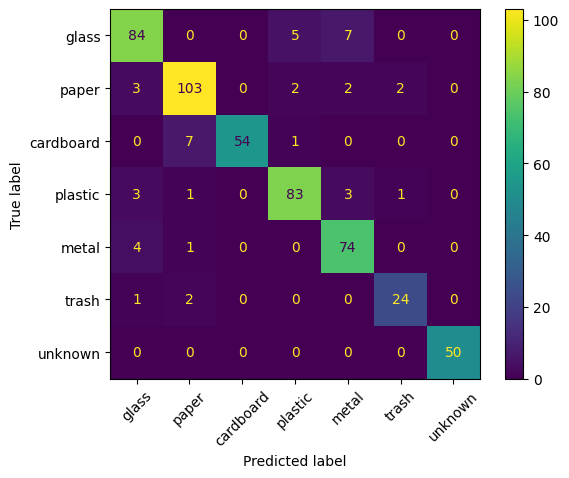

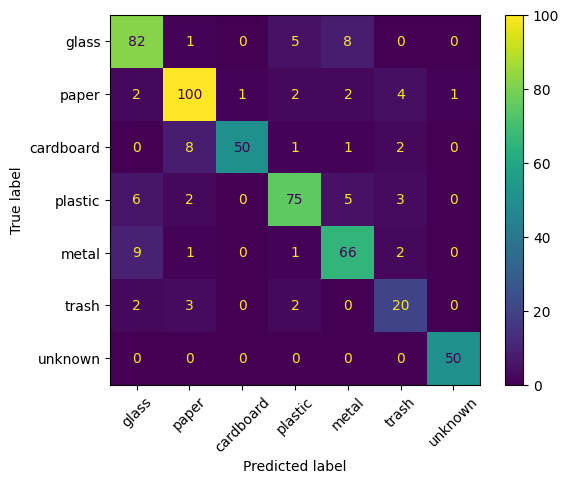

In [197]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

cm = confusion_matrix(test_labels, svc_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.show()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

cm = confusion_matrix(test_labels, knn_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.show()